In [44]:
from river.datasets.synth import FriedmanDrift 
from river.preprocessing import MinMaxScaler 
from river.metrics import MAE
from river.utils import Rolling
from river.tree import HoeffdingTreeRegressor
from river_torch.regression import Regressor
from torch import nn 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import torch

In [24]:
n_samples = 12500
change_points = (5000, 7500)
friedman = FriedmanDrift(drift_type="gra", position=change_points)

def test_train_eval(model, stream, update_interval=100):
    results = []
    steps = []
    step = 0
    metric = Rolling(MAE(), window_size=400)
    scaler = MinMaxScaler()
    for x, y in tqdm(list(stream)):
        x = scaler.learn_one(x).transform_one(x)
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        metric.update(y, y_pred)
        step += 1
        if step % update_interval == 0:
            results.append(metric.get())
            steps.append(step)
    return steps, results

In [25]:
class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.hidden = nn.Linear(n_features, 20)
        self.logit = nn.Linear(20, 1)

    def forward(self, x):
        h = self.hidden(x)
        h = torch.relu(h)
        return self.logit(h)


mlp = Regressor(
    SimpleMLP,
    loss_fn="l1",
    optimizer_fn="adam",
    lr=0.005,
    seed=42,
)
steps, results_mlp = test_train_eval(mlp, friedman.take(n_samples))


100%|██████████| 12500/12500 [00:14<00:00, 892.13it/s] 


In [47]:
tree = HoeffdingTreeRegressor()
steps, results_tree = test_train_eval(tree, friedman.take(n_samples))

100%|██████████| 12500/12500 [00:06<00:00, 1866.62it/s]


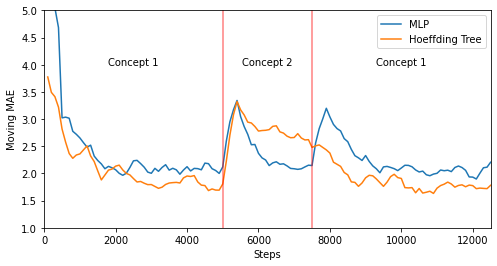

In [48]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(steps, results_mlp, label="MLP")
ax.plot(steps, results_tree, label="Hoeffding Tree")
for change_point in change_points:
    ax.axvline(change_point, color="red", alpha=0.5)
ax.set_xlim(0, n_samples)
ax.set_ylim(1, 5)
plt.text(int(change_points[0] / 2), 4, "Concept 1", horizontalalignment="center")
plt.text(
    int(change_points[0] + (change_points[1] - change_points[0]) / 2),
    4,
    "Concept 2",
    horizontalalignment="center",
)
plt.text(
    int(change_points[1] + (n_samples - change_points[1]) / 2),
    4,
    "Concept 1",
    horizontalalignment="center",
)

ax.set_xlabel("Steps")
ax.set_ylabel("Moving MAE")
ax.legend()
